# Forecasting with FB Prophet

https://facebook.github.io/prophet/

From the facebook page...

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."



This python program will forecast out the stock price of the chosen company AMD. 
This will be the first program of two to attempt to accurately forecast stick prices. 

Stock data is time series although there is no real seasionality persay although AMD may have some seasonality in there data due to an increase in their processors during the November and December time frames. Will this mean an increase in stock price? We will see. 

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import pandas_datareader as web
import numpy as np

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**There will be two ways we want to forecast. 
The first will be to take the daily data. 
The second method will be to resample the dataset to a Monthly and Yearly data set to compare with the daily.**

# Import / Scrape Data

In [2]:
# Lets grab the data from Yahoo and store the vairable as amd which is the name of the stock
# Grab the data for AMD
amd = web.DataReader('AMD', data_source='yahoo', start = "2013-01-01", end = '2020-07-10')

# From here we can split the methods by storing different variables
# amd will ocntinue to be our original method to forecast by day
# The second method will be stored in two variables

amd_m2_year = amd
amd_m2_month = amd

# This is necessary as we want to resample the data which summarizes the data into months as well as years
# To do this in the next section we need to take the index and pop it off to make it a column as 
# the current index is the date format and we cannot run Prophet without a data column. 

# Resample split data from above

In [3]:
# Resample the data to month and year as well as quarter
# Gives us different forecasting options

amd_month = amd_m2_month.resample("M").mean()
amd_quarter = amd_m2_month.resample("3M").mean()
amd_year = amd_m2_year.resample("Y").mean()

Re-Index the data

This has to  be done after resampling
Average has to be run. 

(.sum() can also be used but not relevant since we dont want a summary of stock prices)

In [4]:
# This resets the index and pushes out the Date which was our original index and now we can use it for forecasting
# If drop is = to True, this will drop the Date index since this was our original index and we will get a default index. 
# We want to set drop = False since we want a new index but still want to keep the Date column for forecasting. 
# We also want to keep inplace as True. If False, the Date column stays in the index. 

amd.reset_index(inplace = True, drop = False)

# The same will be done on the Month, Quarter and Year versions of the data

amd_month.reset_index(inplace = True, drop = False) 
amd_quarter.reset_index(inplace = True, drop = False)
amd_year.reset_index(inplace = True, drop = False)

In [5]:
amd

,Date,High,Low,Open,Close,Volume,Adj Close
0,2013-01-02,2.570000,2.450000,2.550000,2.530000,27214800,2.530000
1,2013-01-03,2.590000,2.460000,2.520000,2.490000,24966900,2.490000
2,2013-01-04,2.590000,2.490000,2.510000,2.590000,22054200,2.590000
3,2013-01-07,2.700000,2.600000,2.610000,2.670000,25575200,2.670000
4,2013-01-08,2.760000,2.640000,2.720000,2.670000,29140800,2.670000
...,...,...,...,...,...,...,...
1889,2020-07-06,53.520000,52.330002,52.900002,53.400002,36769400,53.400002
1890,2020-07-07,54.169998,52.860001,53.279999,52.930000,32153100,52.930000
1891,2020-07-08,53.470001,52.070000,53.009998,53.430000,35608300,53.430000
1892,2020-07-09,57.580002,53.310001,53.520000,57.259998,87216300,57.259998


No handles with labels found to put in legend.


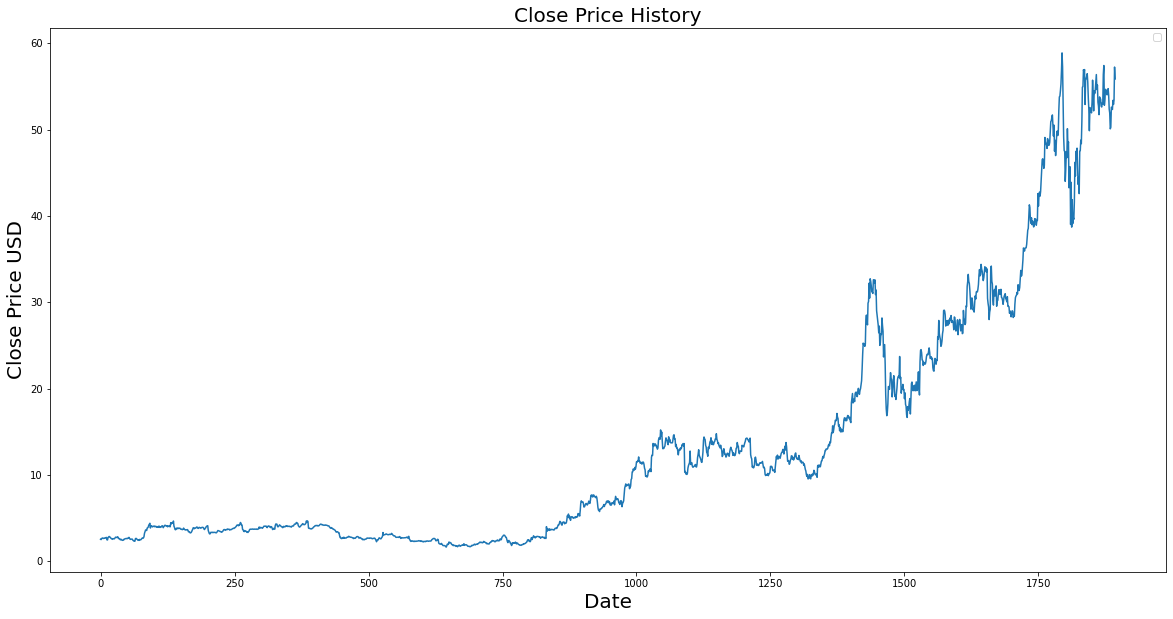

In [5]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History", fontsize = 20)
plt.plot(amd['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


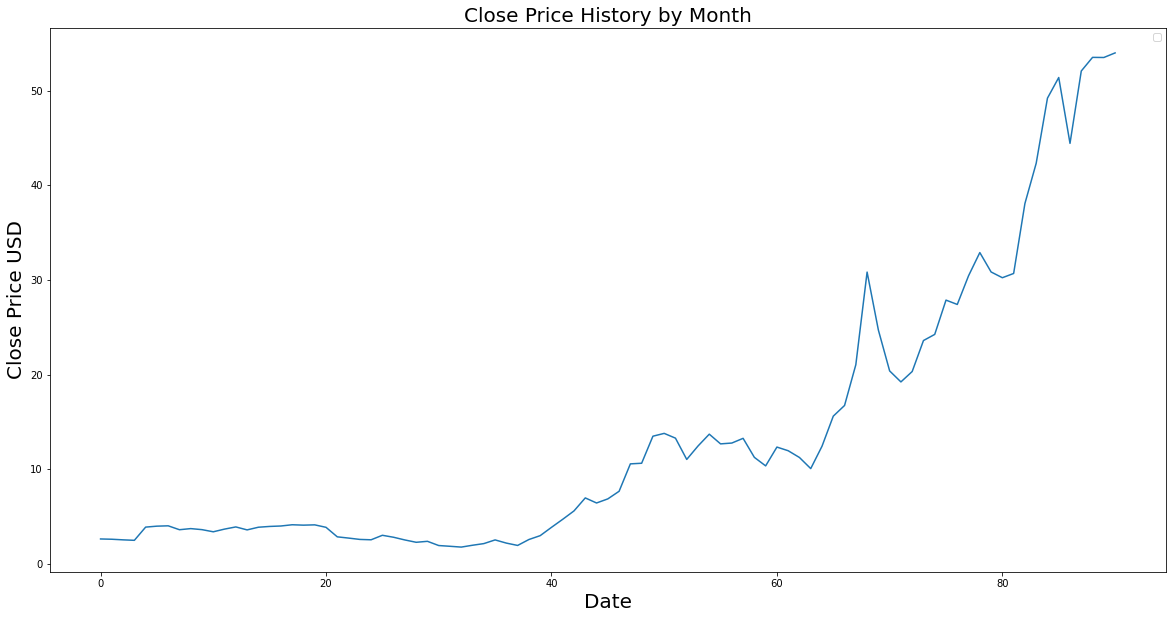

In [6]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Month", fontsize = 20)
plt.plot(amd_month['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


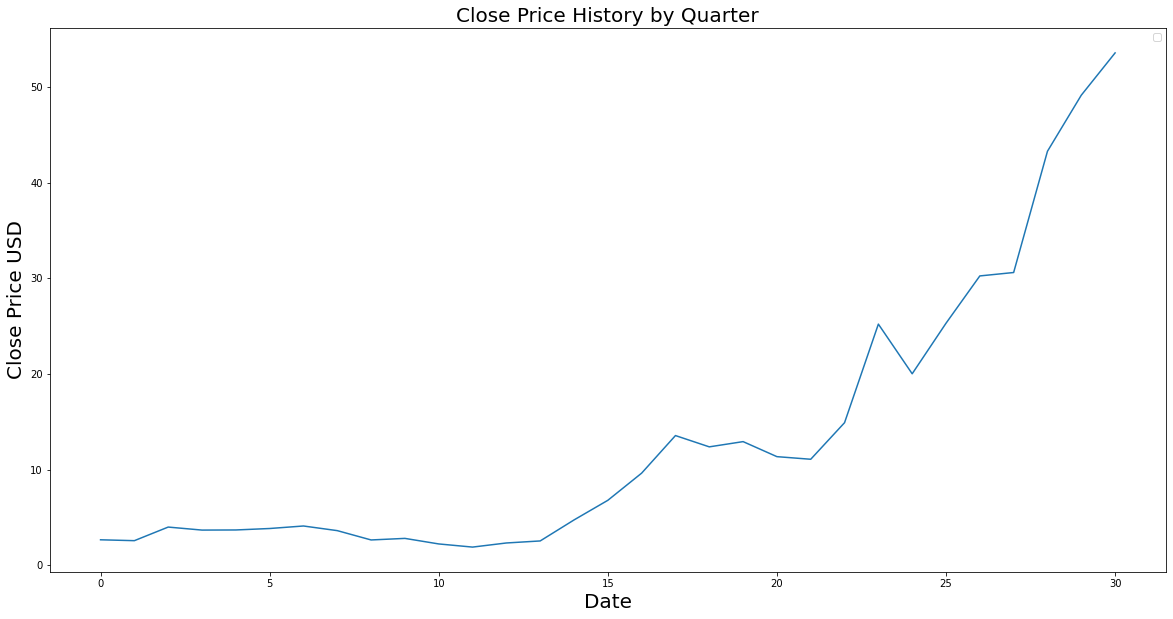

In [7]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Quarter", fontsize = 20)
plt.plot(amd_quarter['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

No handles with labels found to put in legend.


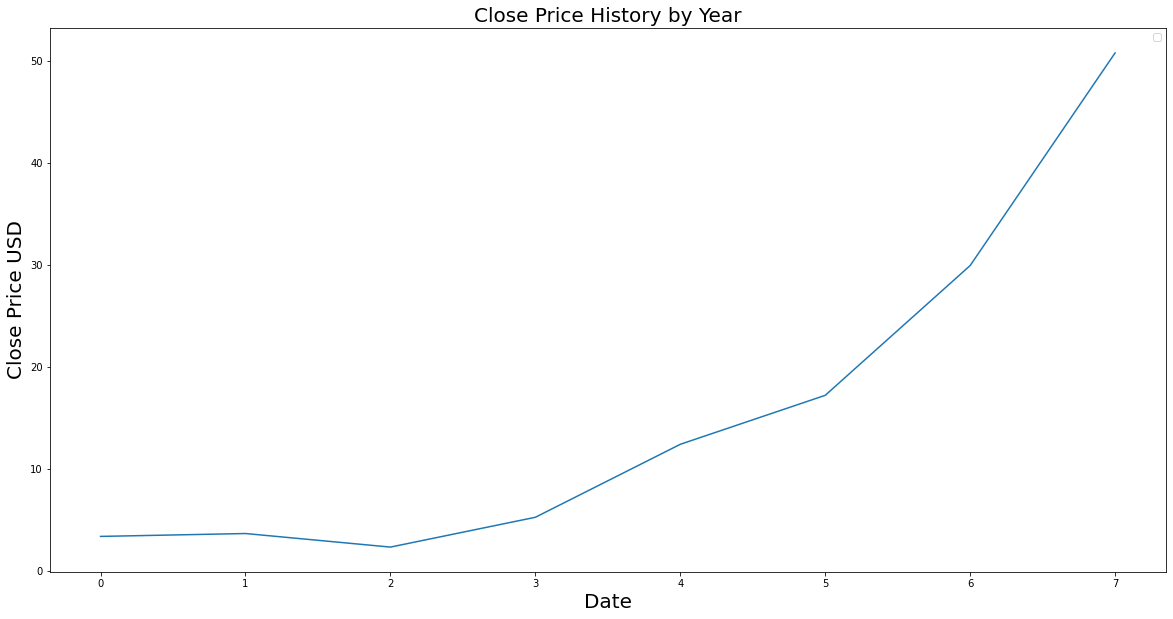

In [8]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Year", fontsize = 20)
plt.plot(amd_year['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

Export the data out to excel if desired

In [9]:
# library needed for google importing or exporting
from google.colab import files

# name your csv
amd.to_csv('amd.csv') 

# download said csv
files.download('amd.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Check to see what kind of data type the data column in
amd.Date.dtype

dtype('<M8[ns]')

No handles with labels found to put in legend.


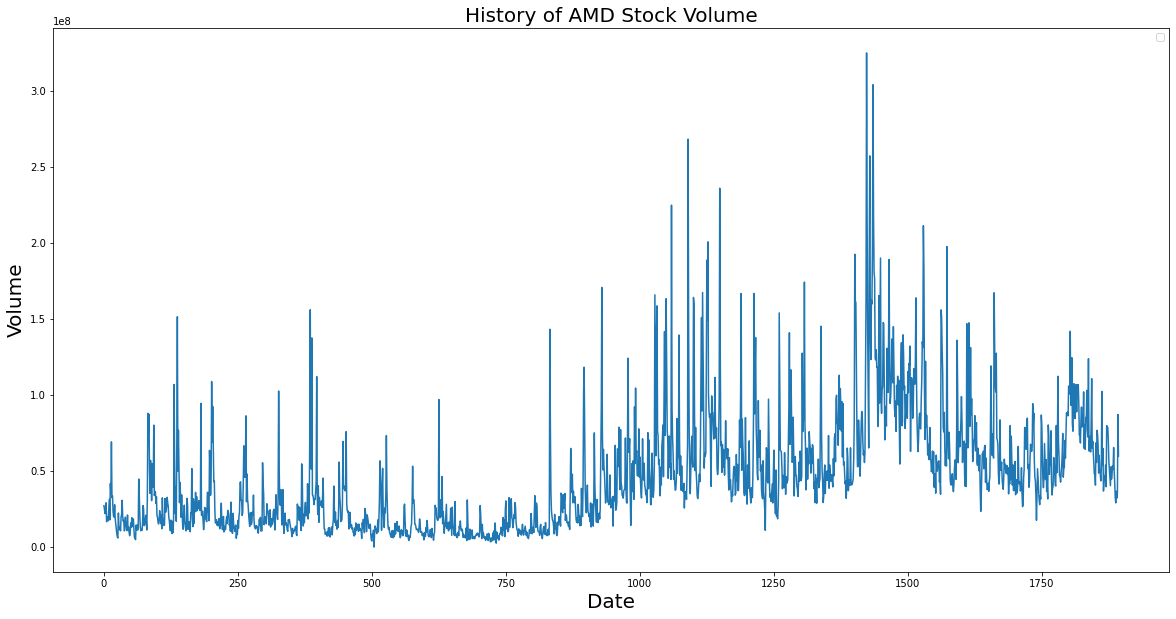

In [10]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("History of AMD Stock Volume", fontsize = 20)
plt.plot(amd['Volume'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Volume', fontsize = 20)
plt.legend()
plt.show()

# Data Prepearation

Daily Data -

In [11]:
# The closing price will be what we forecast
amd_close = amd.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_close['ds'] = pd.to_datetime(amd_close['Date'])
# amd_close['y'] = amd_close['Close'].astype(float)

# Rename the columns
amd_close = amd_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_close

,ds,y
0,2013-01-02,2.530000
1,2013-01-03,2.490000
2,2013-01-04,2.590000
3,2013-01-07,2.670000
4,2013-01-08,2.670000
...,...,...
1889,2020-07-06,53.400002
1890,2020-07-07,52.930000
1891,2020-07-08,53.430000
1892,2020-07-09,57.259998


Monthly, Yearly and Quarterly Data Preprocessing

In [12]:
# The closing price will be what we forecast
amd_month_close = amd_month.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)
amd_quarter_close = amd_quarter.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)
amd_year_close = amd_year.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_month_close['ds'] = pd.to_datetime(amd_month_close['Date'])
# amd_month_close['y'] = amd_month_close['Close'].astype(float)

# Rename the columns
amd_month_close = amd_month_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_quarter_close = amd_quarter_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_year_close = amd_year_close.rename(columns={'Date': 'ds', 'Close': 'y'})

# Just a note, this prepocessed data is ONLY that, it was not used and will not be used in the any modeling. 

# Modeling

# 1st Model
Closing Volume Prediction for the next 2 months (60 days)

In [40]:
# Change the standard 80% to 95%
model = Prophet(interval_width=0.95)
# Let's take out holidays for the US since the stock market wont be open during those days
model = model.add_country_holidays(country_name='US')
# Fit the model
model.fit(amd_close)
# Forecast the future dates based on the data
future_dates = model.make_future_dataframe(periods=60)
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1944,2020-08-30,58.873440,54.917087,62.611777
1945,2020-08-31,58.733471,54.899080,62.781514
1946,2020-09-01,58.881289,55.070368,62.826751
1947,2020-09-02,58.947459,55.169094,62.713356
1948,2020-09-03,59.047911,54.764873,63.332555
1949,2020-09-04,59.116551,54.771126,63.211836
1950,2020-09-05,59.485883,55.678180,63.730702
1951,2020-09-06,59.573662,55.723385,63.596922
1952,2020-09-07,59.406382,55.284201,63.336994
1953,2020-09-08,59.524396,55.588600,63.575979


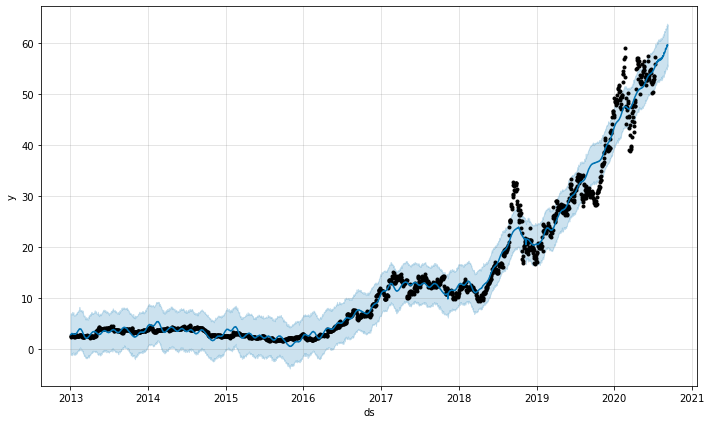

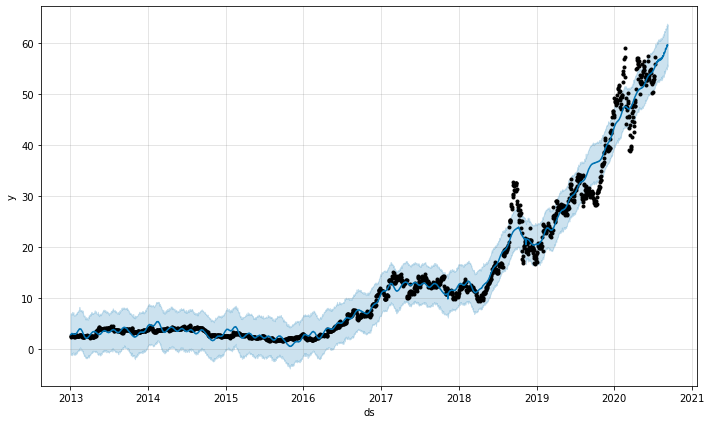

In [41]:
# The black dots is the training data, current known stock prices in this case. 
# The forecasted values are the (blue line) and the uncertainty intervals of our 
# forecasts (the blue shaded regions).
model.plot(forecast, uncertainty = True, xlabel = 'ds', ylabel = 'y')

# Yearly, Day of Week and Monthly Findings

- In the first graph it can be seen that the forecast by mid July is nearly $60. 
- The second graph shows there is generally a spike on Friday's for the AMD stock. 
- Interesetingly in the 4th quarter, around November the stock dips to its lowest of the year but then jumps up in December. This may be caused by Black Friday and Christmas sales. (Additional data may need to be brought in to understand this jump)

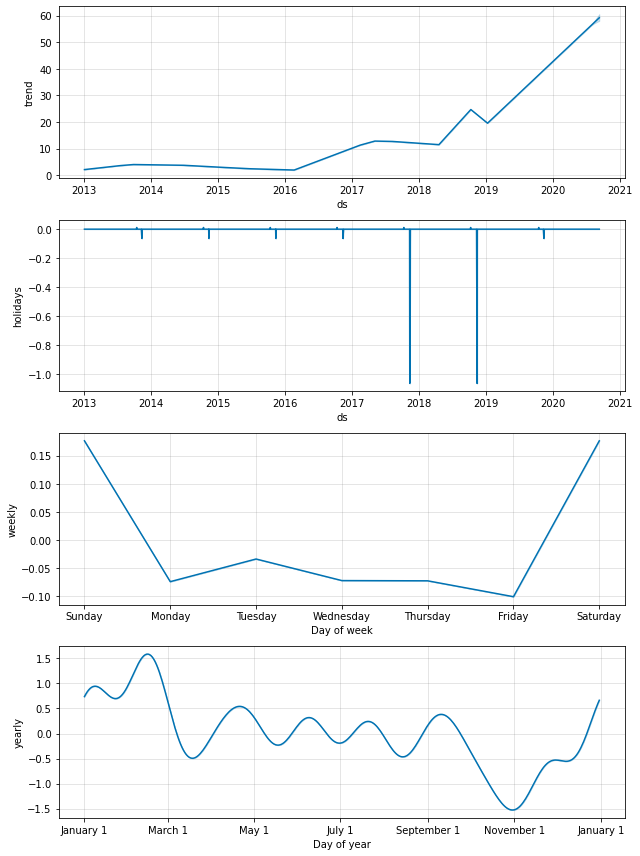

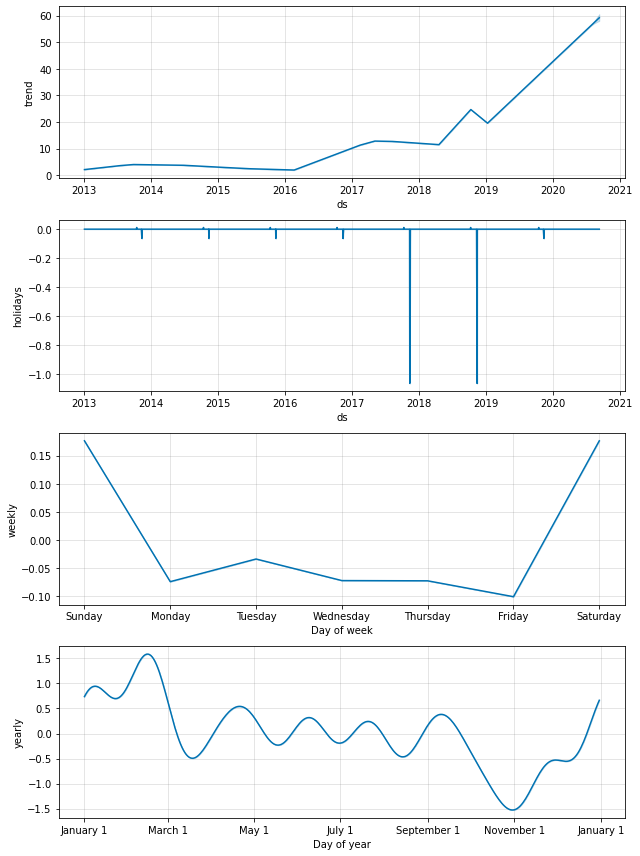

In [42]:
# Daily, weekly and yearly patterns
model.plot_components(forecast)

# Filtered View for Comparison

Let's filter the dataframe by taking out the last 2 months (June and July) to see if prophet can forecast properly. 

This is another way of taking a look at the differences between what is ongoing and what was forecasted. 

In [43]:
# Here we are filtering on a data set to take out all of June and July
filtered_date = amd_close[amd_close["ds"] <= "2020-05-31"]
filtered_date.tail(10)

,ds,y
1855,2020-05-15,54.200001
1856,2020-05-18,54.590000
1857,2020-05-19,55.470001
1858,2020-05-20,56.389999
1859,2020-05-21,54.650002
1860,2020-05-22,55.169998
1861,2020-05-26,53.189999
1862,2020-05-27,52.740002
1863,2020-05-28,51.740002
1864,2020-05-29,53.799999


# 2nd Model

Closing Volume, lets run the model that we have filtered on. This model will predict June and July so that we can see the results as the month progresses. 

In [50]:
# Change the standard 80% to 95%
model_fd = Prophet(interval_width=0.95)
# Let's take out holidays for the US since the stock market wont be open during those days
model_fd = model_fd.add_country_holidays(country_name='US')
# Fit the model
model_fd = model_fd.fit(filtered_date)

# Forecast the future dates based on the data
# The new filtered data date stops at 7/10/2020 therefore the preiod is 42 days
# to forecast so that we can compare the dates up to July 10.  
future_dates_fd = model_fd.make_future_dataframe(periods=42)
forecast_fd = model_fd.predict(future_dates_fd)
forecast_fd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1892,2020-06-26,53.162235,49.146946,57.559678
1893,2020-06-27,53.255163,48.749585,57.441153
1894,2020-06-28,53.316515,49.029342,57.499567
1895,2020-06-29,53.371053,49.088067,57.702992
1896,2020-06-30,53.476675,49.274362,57.854455
1897,2020-07-01,53.501797,49.444296,57.572400
1898,2020-07-02,53.583623,49.259581,58.349800
1899,2020-07-03,53.622001,49.178412,58.010012
1900,2020-07-04,53.729373,49.186854,57.957391
1901,2020-07-05,53.804480,49.291359,57.938736


In [51]:
forecast_fd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,"Martin Luther King, Jr. Day","Martin Luther King, Jr. Day_lower","Martin Luther King, Jr. Day_upper",Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,2.474409,-1.278647,7.492353,2.474409,2.474409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.688334,0.688334,0.688334,0.0,0.0,0.0,-0.008561,-0.008561,-0.008561,0.696895,0.696895,0.696895,0.0,0.0,0.0,3.162744
1,2013-01-03,2.479692,-1.013906,7.010368,2.479692,2.479692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728857,0.728857,0.728857,0.0,0.0,0.0,0.003256,0.003256,0.003256,0.725601,0.725601,0.725601,0.0,0.0,0.0,3.208549
2,2013-01-04,2.484976,-0.704294,7.381613,2.484976,2.484976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.717477,0.717477,0.717477,0.0,0.0,0.0,-0.030286,-0.030286,-0.030286,0.747763,0.747763,0.747763,0.0,0.0,0.0,3.202453
3,2013-01-07,2.500825,-0.915154,7.308500,2.500825,2.500825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769162,0.769162,0.769162,0.0,0.0,0.0,-0.005577,-0.005577,-0.005577,0.774738,0.774738,0.774738,0.0,0.0,0.0,3.269987
4,2013-01-08,2.506109,-1.018603,7.663204,2.506109,2.506109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805496,0.805496,0.805496,0.0,0.0,0.0,0.034263,0.034263,0.034263,0.771233,0.771233,0.771233,0.0,0.0,0.0,3.311605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1902,2020-07-06,53.954365,49.175685,58.192340,53.448777,54.395280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.082610,-0.082610,-0.082610,0.0,0.0,0.0,-0.005577,-0.005577,-0.005577,-0.077033,-0.077033,-0.077033,0.0,0.0,0.0,53.871755
1903,2020-07-07,54.014520,49.628158,58.398769,53.490099,54.470096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.025736,-0.025736,-0.025736,0.0,0.0,0.0,0.034263,0.034263,0.034263,-0.059999,-0.059999,-0.059999,0.0,0.0,0.0,53.988783
1904,2020-07-08,54.074674,49.443558,58.150626,53.531421,54

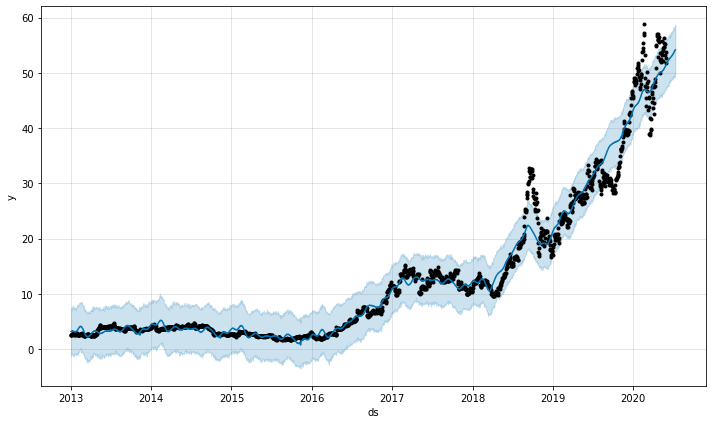

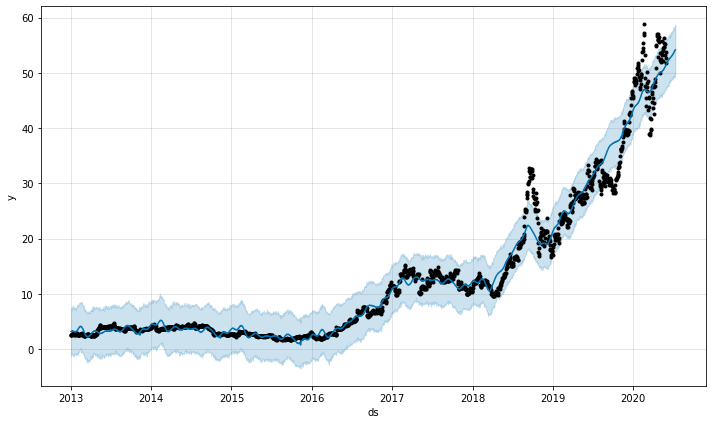

In [52]:
# Prophet plots the observed values of our time series (the black dots), 
# the forecasted values (blue line) and the uncertainty intervals of our 
# forecasts (the blue shaded regions).
model_fd.plot(forecast_fd, uncertainty = True, xlabel = 'ds', ylabel = 'y')

# Comparison

The idea now is to take a look at the output dataframe of the filtered prophet model. We want to take a look at the forecast as we started at the end of May and forecasted until 7/10. Did it match the actuals?

We need to take a look at yhat since this is the forecast value. We should also take a look at yhat_lower and yhat_upper since these are the boundaries. 


In [53]:
# This is the dataframe output of the 2nd model filtered on just the June and July time frame
time_period = forecast_fd[forecast_fd["ds"] > "2020-05-31"]

# Lets rename the column again since the original data frame has a Date column 
# and we can merge the dataframes to make it easier for comparing actual vs
# forecast and build visualizations for. 
time_period = time_period.rename(columns={'ds': 'Date'})

# Let's also trim the output to just include the yhat, yhat_lower and yhat_upper. 
time_period = time_period[["Date", "yhat_lower", "yhat_upper"]]

time_period

,Date,yhat_lower,yhat_upper
1867,2020-06-01,47.343879,55.932679
1868,2020-06-02,47.578259,56.110656
1869,2020-06-03,47.526915,56.022769
1870,2020-06-04,47.487062,56.136582
1871,2020-06-05,47.621685,56.366348
1872,2020-06-06,47.590351,56.289898
1873,2020-06-07,47.881840,56.261729
1874,2020-06-08,47.586025,56.462218
1875,2020-06-09,47.564882,56.701993
1876,2020-06-10,48.144453,56.483584


Now lets trim up the original dataframe to only include the dates that are of interest. 

In [54]:
amd_close_filtered_date = amd_close[amd_close["ds"] > "2020-05-31"]
amd_close_filtered_date

,ds,y
1865,2020-06-01,53.630001
1866,2020-06-02,53.540001
1867,2020-06-03,52.730000
1868,2020-06-04,52.630001
1869,2020-06-05,53.099998
1870,2020-06-08,52.970001
1871,2020-06-09,56.389999
1872,2020-06-10,57.439999
1873,2020-06-11,52.830002
1874,2020-06-12,53.500000


Merge the dateframes based on the date!

Lets make sure our dataframes have the same length. The amount of columns is fine to be different but we do want an exact comparison on dates. 

In [49]:
amd_close_filtered_date.shape

(29, 2)

In [36]:
concatenated = amd_close_filtered_date.join(time_period, lsuffix="_left")
concatenated

,ds,y,Date,yhat_lower,yhat_upper
1865,2020-06-01,53.630001,NaT,NaN,NaN
1866,2020-06-02,53.540001,NaT,NaN,NaN
1867,2020-06-03,52.730000,2020-06-01,47.569189,55.970793
1868,2020-06-04,52.630001,2020-06-02,47.206106,55.979139
1869,2020-06-05,53.099998,2020-06-03,47.529592,56.329596
1870,2020-06-08,52.970001,2020-06-04,47.893140,55.946620
1871,2020-06-09,56.389999,2020-06-05,47.450284,55.907443
1872,2020-06-10,57.439999,2020-06-06,48.109042,56.056810
1873,2020-06-11,52.830002,2020-06-07,47.721367,56.093107
1874,2020-06-12,53.500000,2020-06-08,47.849524,56.753019
